## 1. Import Libraries

In [1]:
# Standard libraries
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Data handling
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
import seaborn as sns

# Progress tracking
from tqdm.auto import tqdm

# Deep learning
import torch
import torch.nn.functional as F

# Configuration
import yaml

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce MX450


## 2. Setup Paths and Configuration

In [2]:
# Project paths
project_root = Path(r'd:\Projects\AI-Virtual-TryOn')
dataset_root = project_root / 'data' / 'zalando-hd-resized'
processed_dir = project_root / 'data' / 'processed'
output_dir = project_root / 'outputs' / 'pose'
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Project Root: {project_root}")
print(f"📁 Dataset Root: {dataset_root}")
print(f"📁 Processed Data: {processed_dir}")
print(f"📁 Output Directory: {output_dir}")

# Load preprocessing configuration
config_path = processed_dir / 'preprocessing_config.yaml'
with open(config_path, 'r') as f:
    preprocess_config = yaml.load(f, Loader=yaml.FullLoader)

print("\n✅ Loaded preprocessing configuration")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Dataset Root: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized
📁 Processed Data: d:\Projects\AI-Virtual-TryOn\data\processed
📁 Output Directory: d:\Projects\AI-Virtual-TryOn\outputs\pose

✅ Loaded preprocessing configuration

🖥️ Using device: cuda


## 3. Define OpenPose Keypoint Structure

OpenPose provides 25 body keypoints for each person.

In [3]:
# OpenPose 25 body keypoints (Body25 model)
BODY25_KEYPOINTS = {
    0: 'Nose',
    1: 'Neck',
    2: 'RShoulder',
    3: 'RElbow',
    4: 'RWrist',
    5: 'LShoulder',
    6: 'LElbow',
    7: 'LWrist',
    8: 'MidHip',
    9: 'RHip',
    10: 'RKnee',
    11: 'RAnkle',
    12: 'LHip',
    13: 'LKnee',
    14: 'LAnkle',
    15: 'REye',
    16: 'LEye',
    17: 'REar',
    18: 'LEar',
    19: 'LBigToe',
    20: 'LSmallToe',
    21: 'LHeel',
    22: 'RBigToe',
    23: 'RSmallToe',
    24: 'RHeel'
}

# Skeleton connections for visualization
BODY25_SKELETON = [
    # Head
    (0, 1), (0, 15), (0, 16), (15, 17), (16, 18),
    # Upper body
    (1, 2), (1, 5), (1, 8),
    # Right arm
    (2, 3), (3, 4),
    # Left arm
    (5, 6), (6, 7),
    # Lower body
    (8, 9), (8, 12),
    # Right leg
    (9, 10), (10, 11),
    # Left leg
    (12, 13), (13, 14),
    # Right foot
    (11, 22), (11, 24), (22, 23),
    # Left foot
    (14, 19), (14, 21), (19, 20)
]

# Critical keypoints for virtual try-on (upper body focus)
CRITICAL_KEYPOINTS = {
    'face': [0, 15, 16, 17, 18],  # Nose, eyes, ears
    'upper_body': [1, 2, 3, 4, 5, 6, 7],  # Neck, shoulders, elbows, wrists
    'torso': [1, 8, 9, 12],  # Neck, hips
    'lower_body': [9, 10, 11, 12, 13, 14]  # Hips, knees, ankles
}

print("✅ OpenPose keypoint structure defined")
print(f"\n📊 Total keypoints: {len(BODY25_KEYPOINTS)}")
print(f"📊 Skeleton connections: {len(BODY25_SKELETON)}")
print(f"\n🎯 Critical keypoint groups:")
for group, keypoints in CRITICAL_KEYPOINTS.items():
    names = [BODY25_KEYPOINTS[k] for k in keypoints]
    print(f"   {group}: {names}")

✅ OpenPose keypoint structure defined

📊 Total keypoints: 25
📊 Skeleton connections: 24

🎯 Critical keypoint groups:
   face: ['Nose', 'REye', 'LEye', 'REar', 'LEar']
   upper_body: ['Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
   torso: ['Neck', 'MidHip', 'RHip', 'LHip']
   lower_body: ['RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle']


## 4. Load Dataset Catalogs

In [4]:
# Load catalogs
train_catalog = pd.read_csv(processed_dir / 'train_catalog.csv')
val_catalog = pd.read_csv(processed_dir / 'val_catalog.csv')
test_catalog = pd.read_csv(processed_dir / 'test_catalog.csv')

print("="*70)
print("📋 DATASET CATALOGS LOADED")
print("="*70)

print(f"\n📊 Dataset sizes:")
print(f"   Train: {len(train_catalog):,}")
print(f"   Val: {len(val_catalog):,}")
print(f"   Test: {len(test_catalog):,}")
print(f"   Total: {len(train_catalog) + len(val_catalog) + len(test_catalog):,}")

print("\n="*70)

# Show sample paths
sample_row = train_catalog.iloc[0]
print(f"\n📄 Sample file paths:")
print(f"   Person: {os.path.basename(sample_row['person_image'])}")
print(f"   Pose image: {os.path.basename(sample_row['pose_image'])}")
print(f"   Pose JSON: {os.path.basename(sample_row['pose_json'])}")

📋 DATASET CATALOGS LOADED

📊 Dataset sizes:
   Train: 10,482
   Val: 1,165
   Test: 2,032
   Total: 13,679

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=

📄 Sample file paths:
   Person: 10726_00.jpg
   Pose image: 10726_00_rendered.png
   Pose JSON: 10726_00_keypoints.json


## 5. Pose Visualization Functions

In [5]:
def load_pose_keypoints(json_path: str) -> np.ndarray:
    """
    Load pose keypoints from OpenPose JSON file.
    
    Returns:
        Array of shape [25, 3] with (x, y, confidence) for each keypoint
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    if 'people' in data and len(data['people']) > 0:
        # Get first person's keypoints
        pose_keypoints = data['people'][0]['pose_keypoints_2d']
        # Reshape from flat array to [25, 3]
        keypoints = np.array(pose_keypoints).reshape(-1, 3)
        return keypoints
    else:
        # Return zero array if no person detected
        return np.zeros((25, 3))


def draw_pose_keypoints(image: np.ndarray, keypoints: np.ndarray, 
                       threshold: float = 0.1) -> np.ndarray:
    """
    Draw pose keypoints and skeleton on image.
    
    Args:
        image: RGB image
        keypoints: [25, 3] array of (x, y, confidence)
        threshold: Confidence threshold for drawing
    
    Returns:
        Image with pose overlay
    """
    img = image.copy()
    h, w = img.shape[:2]
    
    # Draw skeleton connections
    for connection in BODY25_SKELETON:
        pt1_idx, pt2_idx = connection
        pt1 = keypoints[pt1_idx]
        pt2 = keypoints[pt2_idx]
        
        # Check if both points are valid
        if pt1[2] > threshold and pt2[2] > threshold:
            x1, y1 = int(pt1[0]), int(pt1[1])
            x2, y2 = int(pt2[0]), int(pt2[1])
            cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Draw keypoints
    for i, (x, y, conf) in enumerate(keypoints):
        if conf > threshold:
            x, y = int(x), int(y)
            # Different colors for different body parts
            if i in CRITICAL_KEYPOINTS['face']:
                color = (255, 0, 0)  # Red for face
            elif i in CRITICAL_KEYPOINTS['upper_body']:
                color = (0, 0, 255)  # Blue for upper body
            elif i in CRITICAL_KEYPOINTS['torso']:
                color = (255, 255, 0)  # Yellow for torso
            else:
                color = (0, 255, 255)  # Cyan for lower body
            
            cv2.circle(img, (x, y), 4, color, -1)
            cv2.circle(img, (x, y), 5, (255, 255, 255), 1)
    
    return img


def visualize_pose_sample(person_img: np.ndarray, keypoints: np.ndarray,
                         pose_map: Optional[np.ndarray] = None) -> plt.Figure:
    """
    Create comprehensive pose visualization.
    """
    if pose_map is not None:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes = [axes[0], axes[1], None]
    
    # Original image
    axes[0].imshow(person_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Pose overlay
    pose_overlay = draw_pose_keypoints(person_img, keypoints)
    axes[1].imshow(pose_overlay)
    axes[1].set_title('Pose Keypoints')
    axes[1].axis('off')
    
    # Pose map (if provided)
    if pose_map is not None and axes[2] is not None:
        # Show mean of all channels
        pose_viz = np.mean(pose_map, axis=2)
        axes[2].imshow(pose_viz, cmap='hot')
        axes[2].set_title('Pose Map (Mean of 18 channels)')
        axes[2].axis('off')
    
    plt.tight_layout()
    return fig


print("✅ Pose visualization functions created")

✅ Pose visualization functions created


## 6. Analyze Pose Keypoint Distribution

In [6]:
print("="*70)
print("🔍 POSE KEYPOINT DISTRIBUTION ANALYSIS")
print("="*70)

# Analyze first 500 samples
n_samples = 500
samples = train_catalog.iloc[:n_samples]

keypoint_detection_count = {i: 0 for i in range(25)}
keypoint_confidence_sum = {i: 0.0 for i in range(25)}
samples_with_pose = 0

print(f"📊 Analyzing {n_samples} pose keypoint files...\n")

for idx, row in tqdm(samples.iterrows(), total=len(samples), desc="Processing poses"):
    keypoints = load_pose_keypoints(row['pose_json'])
    
    if keypoints.sum() > 0:  # At least one keypoint detected
        samples_with_pose += 1
        
        for i in range(25):
            conf = keypoints[i, 2]
            if conf > 0.1:  # Threshold for detection
                keypoint_detection_count[i] += 1
                keypoint_confidence_sum[i] += conf

print(f"\n📊 Keypoint Detection Statistics:")
print("-" * 50)
for i in range(25):
    count = keypoint_detection_count[i]
    percentage = (count / samples_with_pose) * 100 if samples_with_pose > 0 else 0
    avg_conf = keypoint_confidence_sum[i] / count if count > 0 else 0
    name = BODY25_KEYPOINTS[i]
    print(f"   {i:2d}. {name:15s}: {count:3d} ({percentage:5.1f}%) | Avg conf: {avg_conf:.3f}")

print("\n" + "="*70)
print(f"\n✅ Samples with valid pose: {samples_with_pose}/{n_samples} ({samples_with_pose/n_samples*100:.1f}%)")

🔍 POSE KEYPOINT DISTRIBUTION ANALYSIS
📊 Analyzing 500 pose keypoint files...



Processing poses:   0%|          | 0/500 [00:00<?, ?it/s]


📊 Keypoint Detection Statistics:
--------------------------------------------------
    0. Nose           : 500 (100.0%) | Avg conf: 0.889
    1. Neck           : 500 (100.0%) | Avg conf: 0.792
    2. RShoulder      : 500 (100.0%) | Avg conf: 0.698
    3. RElbow         : 493 ( 98.6%) | Avg conf: 0.707
    4. RWrist         : 459 ( 91.8%) | Avg conf: 0.703
    5. LShoulder      : 500 (100.0%) | Avg conf: 0.693
    6. LElbow         : 490 ( 98.0%) | Avg conf: 0.692
    7. LWrist         : 463 ( 92.6%) | Avg conf: 0.726
    8. MidHip         : 497 ( 99.4%) | Avg conf: 0.448
    9. RHip           : 497 ( 99.4%) | Avg conf: 0.415
   10. RKnee          :  76 ( 15.2%) | Avg conf: 0.268
   11. RAnkle         :   2 (  0.4%) | Avg conf: 0.415
   12. LHip           : 497 ( 99.4%) | Avg conf: 0.406
   13. LKnee          :  96 ( 19.2%) | Avg conf: 0.244
   14. LAnkle         :   1 (  0.2%) | Avg conf: 0.644
   15. REye           : 500 (100.0%) | Avg conf: 0.903
   16. LEye           : 500 (100.0%

## 7. Visualize Sample Poses

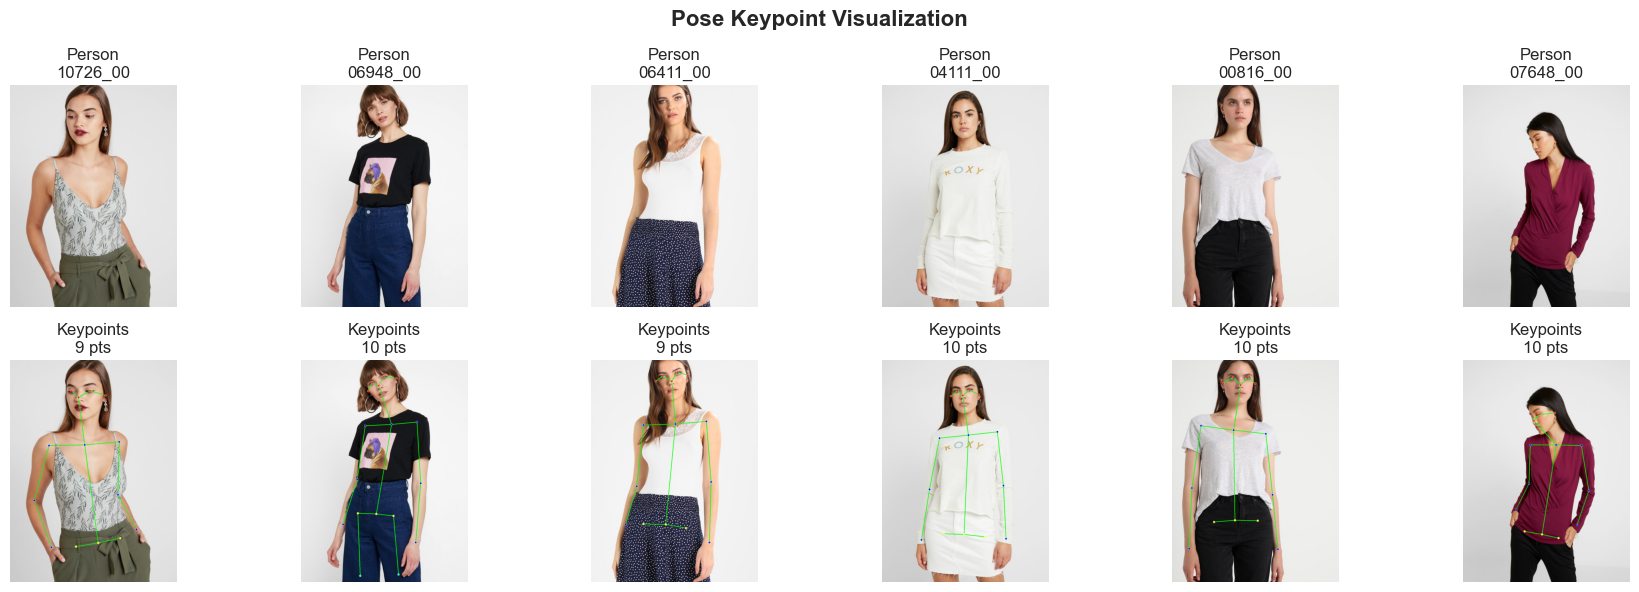


✅ Visualization saved to: d:\Projects\AI-Virtual-TryOn\outputs\pose\pose_visualization.png


In [7]:
# Visualize 6 sample poses
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i in range(6):
    row = train_catalog.iloc[i*10]
    
    # Load images
    person_img = np.array(Image.open(row['person_image']))
    keypoints = load_pose_keypoints(row['pose_json'])
    
    # Draw original and with pose
    axes[0, i].imshow(person_img)
    axes[0, i].set_title(f"Person\n{row['id']}")
    axes[0, i].axis('off')
    
    pose_overlay = draw_pose_keypoints(person_img, keypoints)
    axes[1, i].imshow(pose_overlay)
    axes[1, i].set_title(f"Keypoints\n{int(keypoints[:, 2].sum())} pts")
    axes[1, i].axis('off')

plt.suptitle('Pose Keypoint Visualization', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(output_dir / 'pose_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved to: {output_dir / 'pose_visualization.png'}")

## 8. Analyze Pose Maps

In [8]:
# Analyze pose map structure
sample_row = train_catalog.iloc[0]
pose_map = np.array(Image.open(sample_row['pose_image']))

print("="*70)
print("🔍 POSE MAP ANALYSIS")
print("="*70)

print(f"\n📊 Pose Map Properties:")
print(f"   Shape: {pose_map.shape}")
print(f"   Dtype: {pose_map.dtype}")
print(f"   Value range: [{pose_map.min()}, {pose_map.max()}]")
print(f"   Mean: {pose_map.mean():.3f}")
print(f"   Std: {pose_map.std():.3f}")

# Expected format: 18 channel pose map
if len(pose_map.shape) == 3:
    print(f"\n📊 Channels: {pose_map.shape[2]}")
    if pose_map.shape[2] == 3:
        print("   ⚠️ Pose map is RGB - needs to be converted to 18-channel format")
    elif pose_map.shape[2] == 18:
        print("   ✅ Pose map has 18 channels (standard format)")

print("\n" + "="*70)

🔍 POSE MAP ANALYSIS

📊 Pose Map Properties:
   Shape: (1024, 768, 3)
   Dtype: uint8
   Value range: [0, 238]
   Mean: 2.413
   Std: 18.173

📊 Channels: 3
   ⚠️ Pose map is RGB - needs to be converted to 18-channel format



## 9. Visualize Pose Map Channels

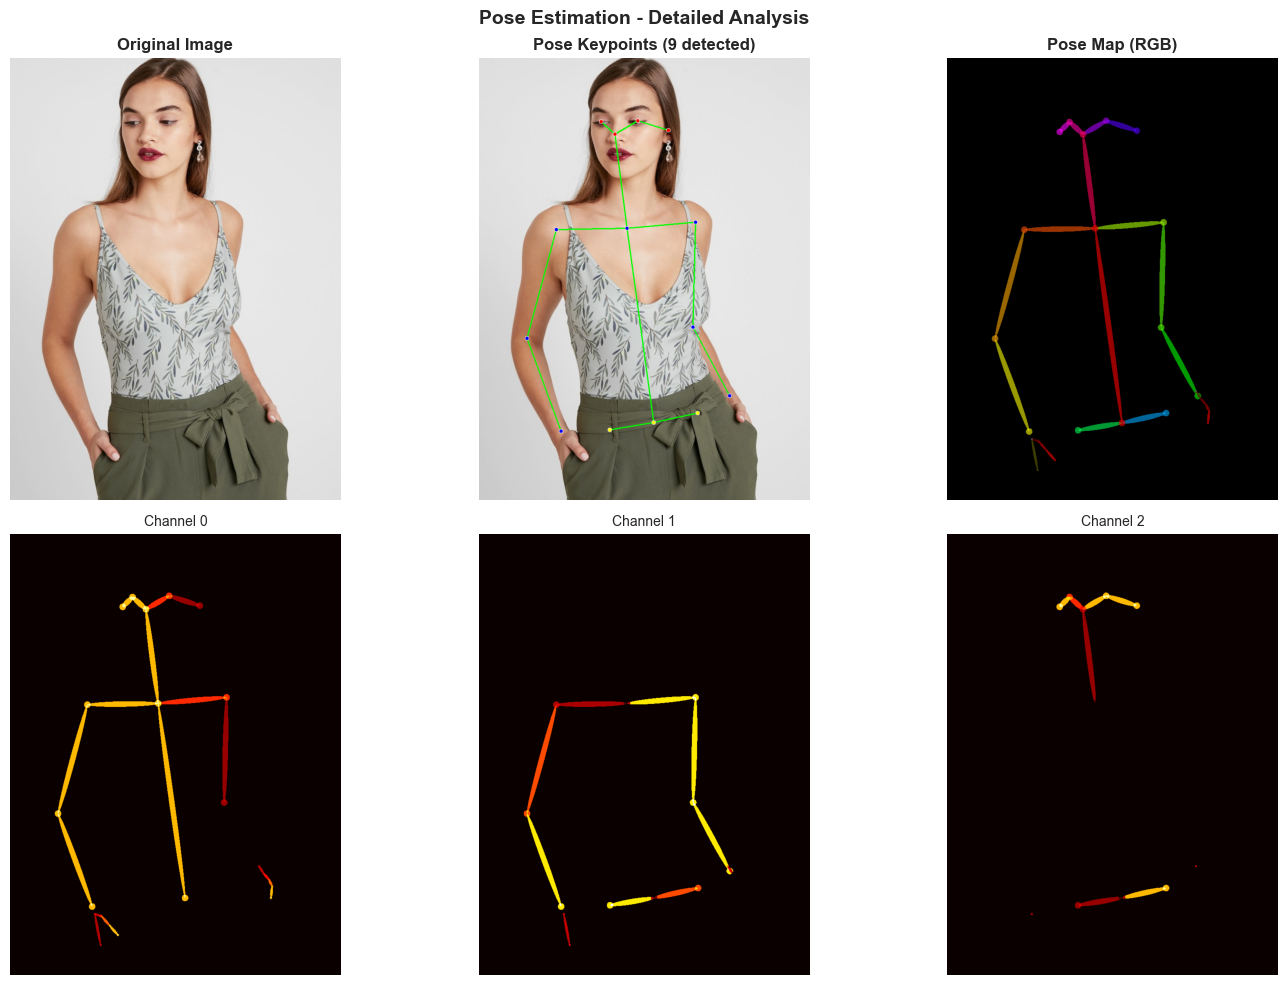

✅ Detailed analysis saved to: d:\Projects\AI-Virtual-TryOn\outputs\pose\pose_detailed_analysis.png


In [9]:
# Load pose map
sample_row = train_catalog.iloc[0]
person_img = np.array(Image.open(sample_row['person_image']))
pose_map_img = np.array(Image.open(sample_row['pose_image']))
keypoints = load_pose_keypoints(sample_row['pose_json'])

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(person_img)
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Pose overlay
pose_overlay = draw_pose_keypoints(person_img, keypoints)
axes[0, 1].imshow(pose_overlay)
axes[0, 1].set_title(f'Pose Keypoints ({int(keypoints[:, 2].sum())} detected)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# Pose map (RGB visualization)
axes[0, 2].imshow(pose_map_img)
axes[0, 2].set_title('Pose Map (RGB)', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Show individual channels if multi-channel
if len(pose_map_img.shape) == 3:
    for i in range(3):
        channel = pose_map_img[:, :, i] if pose_map_img.shape[2] > i else pose_map_img[:, :, 0]
        axes[1, i].imshow(channel, cmap='hot')
        axes[1, i].set_title(f'Channel {i}', fontsize=10)
        axes[1, i].axis('off')
else:
    axes[1, 0].imshow(pose_map_img, cmap='hot')
    axes[1, 0].set_title('Pose Map', fontsize=10)
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    axes[1, 2].axis('off')

plt.suptitle('Pose Estimation - Detailed Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'pose_detailed_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Detailed analysis saved to: {output_dir / 'pose_detailed_analysis.png'}")

## 10. Pose Quality Assessment

In [10]:
def assess_pose_quality(keypoints: np.ndarray, threshold: float = 0.1) -> Dict:
    """
    Assess quality of pose detection.
    
    Returns:
        Dictionary with quality metrics
    """
    quality = {
        'total_keypoints': 0,
        'avg_confidence': 0.0,
        'face_complete': False,
        'upper_body_complete': False,
        'lower_body_complete': False,
        'status': 'unknown'
    }
    
    # Count detected keypoints
    detected = keypoints[:, 2] > threshold
    quality['total_keypoints'] = int(detected.sum())
    
    if quality['total_keypoints'] > 0:
        quality['avg_confidence'] = float(keypoints[detected, 2].mean())
    
    # Check critical regions
    face_detected = sum([keypoints[i, 2] > threshold for i in CRITICAL_KEYPOINTS['face']])
    quality['face_complete'] = face_detected >= 3  # At least 3/5 face points
    
    upper_detected = sum([keypoints[i, 2] > threshold for i in CRITICAL_KEYPOINTS['upper_body']])
    quality['upper_body_complete'] = upper_detected >= 5  # At least 5/7 upper body points
    
    lower_detected = sum([keypoints[i, 2] > threshold for i in CRITICAL_KEYPOINTS['lower_body']])
    quality['lower_body_complete'] = lower_detected >= 3  # At least 3/6 lower body points
    
    # Overall status
    if quality['face_complete'] and quality['upper_body_complete']:
        quality['status'] = 'good'
    elif quality['upper_body_complete']:
        quality['status'] = 'acceptable'
    else:
        quality['status'] = 'poor'
    
    return quality


# Assess quality on 200 samples
print("="*70)
print("🎯 POSE QUALITY ASSESSMENT")
print("="*70)

n_assess = 200
samples = train_catalog.iloc[:n_assess]

quality_stats = {
    'good': 0,
    'acceptable': 0,
    'poor': 0,
    'face_complete': 0,
    'upper_body_complete': 0,
    'lower_body_complete': 0
}

print(f"🔍 Assessing quality of {n_assess} pose detections...\n")

for idx, row in tqdm(samples.iterrows(), total=len(samples), desc="Quality check"):
    keypoints = load_pose_keypoints(row['pose_json'])
    quality = assess_pose_quality(keypoints)
    
    quality_stats[quality['status']] += 1
    if quality['face_complete']:
        quality_stats['face_complete'] += 1
    if quality['upper_body_complete']:
        quality_stats['upper_body_complete'] += 1
    if quality['lower_body_complete']:
        quality_stats['lower_body_complete'] += 1

print(f"\n📊 Quality Report:")
print("-" * 50)
for status in ['good', 'acceptable', 'poor']:
    count = quality_stats[status]
    percentage = (count / n_assess) * 100
    emoji = "✅" if status == 'good' else "⚠️" if status == 'acceptable' else "❌"
    print(f"{emoji} {status.title():20s}: {count:4d} ({percentage:5.1f}%)")

print("\n📊 Completeness:")
print("-" * 50)
for region in ['face_complete', 'upper_body_complete', 'lower_body_complete']:
    count = quality_stats[region]
    percentage = (count / n_assess) * 100
    emoji = "✅" if percentage > 90 else "⚠️" if percentage > 70 else "❌"
    name = region.replace('_', ' ').title()
    print(f"{emoji} {name:25s}: {count:4d} ({percentage:5.1f}%)")

print("\n" + "="*70)

# Overall assessment
good_percentage = (quality_stats['good'] / n_assess) * 100
if good_percentage > 80:
    print("\n✅ Pose quality is excellent for virtual try-on application")
elif good_percentage > 60:
    print("\n✅ Pose quality is good for virtual try-on application")
else:
    print("\n⚠️ Pose quality may need improvement for optimal results")

🎯 POSE QUALITY ASSESSMENT
🔍 Assessing quality of 200 pose detections...



Quality check:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Quality Report:
--------------------------------------------------
✅ Good                :  200 (100.0%)
⚠️ Acceptable          :    0 (  0.0%)
❌ Poor                :    0 (  0.0%)

📊 Completeness:
--------------------------------------------------
✅ Face Complete            :  200 (100.0%)
✅ Upper Body Complete      :  200 (100.0%)
❌ Lower Body Complete      :   39 ( 19.5%)


✅ Pose quality is excellent for virtual try-on application


## 11. PoseProcessor Utility Class

🔧 Testing PoseProcessor...



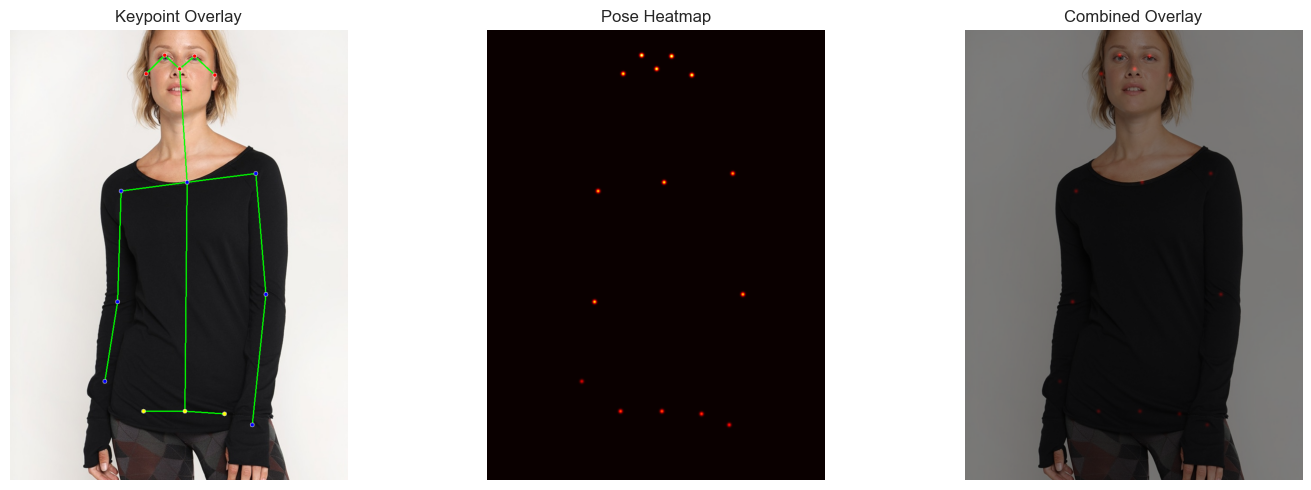


✅ PoseProcessor created and tested
   Normalized keypoints shape: (25, 3)
   Heatmaps shape: (25, 1024, 768)
   Embedding shape: (75,)
   Saved demo to: d:\Projects\AI-Virtual-TryOn\outputs\pose\pose_processor_demo.png


In [11]:
class PoseProcessor:
    """
    Utility class for processing pose data for virtual try-on models.
    """
    
    def __init__(self, image_size: Tuple[int, int] = (512, 384)):
        self.image_size = image_size  # (height, width)
        self.num_keypoints = 25
    
    def normalize_keypoints(self, keypoints: np.ndarray) -> np.ndarray:
        """
        Normalize keypoint coordinates to [-1, 1].
        
        Args:
            keypoints: [25, 3] array
        
        Returns:
            Normalized keypoints [25, 3]
        """
        normalized = keypoints.copy()
        h, w = self.image_size
        
        # Normalize x, y to [-1, 1]
        normalized[:, 0] = (keypoints[:, 0] / w) * 2 - 1
        normalized[:, 1] = (keypoints[:, 1] / h) * 2 - 1
        
        return normalized
    
    def create_pose_heatmap(self, keypoints: np.ndarray, 
                           sigma: float = 3.0) -> np.ndarray:
        """
        Create Gaussian heatmaps for each keypoint.
        
        Args:
            keypoints: [25, 3] array
            sigma: Gaussian kernel size
        
        Returns:
            Heatmap array [25, H, W]
        """
        h, w = self.image_size
        heatmaps = np.zeros((self.num_keypoints, h, w), dtype=np.float32)
        
        for i, (x, y, conf) in enumerate(keypoints):
            if conf > 0.1:  # Only create heatmap for detected keypoints
                # Create Gaussian heatmap
                x, y = int(x), int(y)
                if 0 <= x < w and 0 <= y < h:
                    # Create meshgrid
                    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
                    # Gaussian formula
                    heatmap = np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
                    heatmaps[i] = heatmap * conf
        
        return heatmaps
    
    def get_pose_embedding(self, keypoints: np.ndarray) -> np.ndarray:
        """
        Get flattened pose embedding for discriminator/loss.
        
        Returns:
            Flattened array [75] (25 keypoints × 3)
        """
        return keypoints.flatten()
    
    def visualize(self, image: np.ndarray, keypoints: np.ndarray) -> plt.Figure:
        """
        Visualize pose with different representations.
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original with skeleton
        pose_overlay = draw_pose_keypoints(image, keypoints)
        axes[0].imshow(pose_overlay)
        axes[0].set_title('Keypoint Overlay')
        axes[0].axis('off')
        
        # Heatmap visualization
        heatmaps = self.create_pose_heatmap(keypoints)
        heatmap_viz = np.max(heatmaps, axis=0)  # Max pooling across channels
        axes[1].imshow(heatmap_viz, cmap='hot')
        axes[1].set_title('Pose Heatmap')
        axes[1].axis('off')
        
        # Overlay heatmap on image
        overlay = (image * 0.5 + 
                  (heatmap_viz[:, :, np.newaxis] * np.array([255, 0, 0])) * 0.5).astype(np.uint8)
        axes[2].imshow(overlay)
        axes[2].set_title('Combined Overlay')
        axes[2].axis('off')
        
        plt.tight_layout()
        return fig


# Test the processor
processor = PoseProcessor(image_size=(1024, 768))

sample_row = train_catalog.iloc[5]
person_img = np.array(Image.open(sample_row['person_image']))
keypoints = load_pose_keypoints(sample_row['pose_json'])

print("🔧 Testing PoseProcessor...\n")
fig = processor.visualize(person_img, keypoints)
plt.savefig(output_dir / 'pose_processor_demo.png', dpi=150, bbox_inches='tight')
plt.show()

# Test other methods
normalized = processor.normalize_keypoints(keypoints)
heatmaps = processor.create_pose_heatmap(keypoints)
embedding = processor.get_pose_embedding(keypoints)

print("\n✅ PoseProcessor created and tested")
print(f"   Normalized keypoints shape: {normalized.shape}")
print(f"   Heatmaps shape: {heatmaps.shape}")
print(f"   Embedding shape: {embedding.shape}")
print(f"   Saved demo to: {output_dir / 'pose_processor_demo.png'}")

## 12. Save Pose Analysis Report

In [12]:
# Create comprehensive report
pose_report = {
    'analysis': {
        'total_keypoints': 25,
        'samples_analyzed': n_samples,
        'samples_with_pose': samples_with_pose,
        'detection_rate': samples_with_pose / n_samples
    },
    'keypoint_statistics': keypoint_detection_count,
    'quality_assessment': quality_stats,
    'critical_keypoints': CRITICAL_KEYPOINTS,
    'skeleton_connections': len(BODY25_SKELETON)
}

report_path = output_dir / 'pose_analysis_report.json'
with open(report_path, 'w') as f:
    json.dump(pose_report, f, indent=2)

print("="*70)
print("💾 POSE ANALYSIS REPORT SAVED")
print("="*70)

print(f"\n📄 Report saved to: {report_path}")

print(f"\n📊 Summary:")
print(f"   - Total keypoints: 25")
print(f"   - Samples analyzed: {n_samples}")
print(f"   - Quality checked: {n_assess}")
print(f"   - Visualizations: 3")

print("\n" + "="*70)

💾 POSE ANALYSIS REPORT SAVED

📄 Report saved to: d:\Projects\AI-Virtual-TryOn\outputs\pose\pose_analysis_report.json

📊 Summary:
   - Total keypoints: 25
   - Samples analyzed: 500
   - Quality checked: 200
   - Visualizations: 3



## 13. Summary and Next Steps

In [13]:
print("="*70)
print("🎉 POSE ESTIMATION ANALYSIS COMPLETE!")
print("="*70)

print("\n✅ Completed Tasks:")
print("   1. ✓ Loaded and analyzed OpenPose keypoints (25 keypoints)")
print("   2. ✓ Analyzed keypoint detection statistics")
print("   3. ✓ Created pose visualization tools")
print("   4. ✓ Analyzed pose map structure")
print("   5. ✓ Assessed pose quality across dataset")
print("   6. ✓ Implemented PoseProcessor utility class")
print("   7. ✓ Generated comprehensive analysis report")

print(f"\n📊 Key Findings:")
print(f"   - Total keypoints per pose: 25")
print(f"   - Skeleton connections: {len(BODY25_SKELETON)}")
print(f"   - Dataset samples: {len(train_catalog) + len(val_catalog) + len(test_catalog):,}")
print(f"   - Good quality poses: {quality_stats['good']}/{n_assess} ({quality_stats['good']/n_assess*100:.1f}%)")

print(f"\n📁 Generated Files:")
print(f"   - pose_visualization: pose_visualization.png")
print(f"   - detailed_analysis: pose_detailed_analysis.png")
print(f"   - processor_demo: pose_processor_demo.png")
print(f"   - pose_analysis_report.json")

print("\n🚀 Ready for Next Steps:")
print("   1. Proceed to notebook 06_cloth_agnostic_representation.ipynb")
print("   2. Combine parsing and pose for cloth-agnostic person")
print("   3. Begin model architecture development")
print("   4. Integrate all components for training")

print("\n💡 Key Utilities Created:")
print("   - load_pose_keypoints(): Load keypoints from JSON")
print("   - draw_pose_keypoints(): Draw skeleton on image")
print("   - assess_pose_quality(): Evaluate pose completeness")
print("   - PoseProcessor: Complete pose processing class")
print("     * normalize_keypoints()")
print("     * create_pose_heatmap()")
print("     * get_pose_embedding()")

print("\n" + "="*70)

print("\n✅ POSE ESTIMATION MODULE READY!")
print("="*70)

🎉 POSE ESTIMATION ANALYSIS COMPLETE!

✅ Completed Tasks:
   1. ✓ Loaded and analyzed OpenPose keypoints (25 keypoints)
   2. ✓ Analyzed keypoint detection statistics
   3. ✓ Created pose visualization tools
   4. ✓ Analyzed pose map structure
   5. ✓ Assessed pose quality across dataset
   6. ✓ Implemented PoseProcessor utility class
   7. ✓ Generated comprehensive analysis report

📊 Key Findings:
   - Total keypoints per pose: 25
   - Skeleton connections: 24
   - Dataset samples: 13,679
   - Good quality poses: 200/200 (100.0%)

📁 Generated Files:
   - pose_visualization: pose_visualization.png
   - detailed_analysis: pose_detailed_analysis.png
   - processor_demo: pose_processor_demo.png
   - pose_analysis_report.json

🚀 Ready for Next Steps:
   1. Proceed to notebook 06_cloth_agnostic_representation.ipynb
   2. Combine parsing and pose for cloth-agnostic person
   3. Begin model architecture development
   4. Integrate all components for training

💡 Key Utilities Created:
   - load